# Convolution and Wavelet Transform of Solar Sunspot Activity: Capturing Time–Frequency Structure

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load daily sunspot dataset
csv_path = "daily_sunspots_time_series_1850-01_2025-01.csv"  
df = pd.read_csv(csv_path)

# 2) Parse dates and set index
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")

# 3) Build monthly mean time series
ts_monthly = df["counts"].astype(float).resample("M").mean().dropna()

# 4) Quick check
print("Number of monthly points:", len(ts_monthly))
print(ts_monthly.head())
print(ts_monthly.tail())


Number of monthly points: 2101
date
1850-01-31    148.225806
1850-02-28    169.750000
1850-03-31    156.838710
1850-04-30     83.833333
1850-05-31    117.032258
Freq: ME, Name: counts, dtype: float64
date
2024-09-30    141.100000
2024-10-31    166.387097
2024-11-30    152.466667
2024-12-31    154.516129
2025-01-31    137.000000
Freq: ME, Name: counts, dtype: float64


/var/folders/n4/8n2hpd_912g5cknmv3k37fjm0000gn/T/ipykernel_73214/1132588408.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_monthly = df["counts"].astype(float).resample("M").mean().dropna()


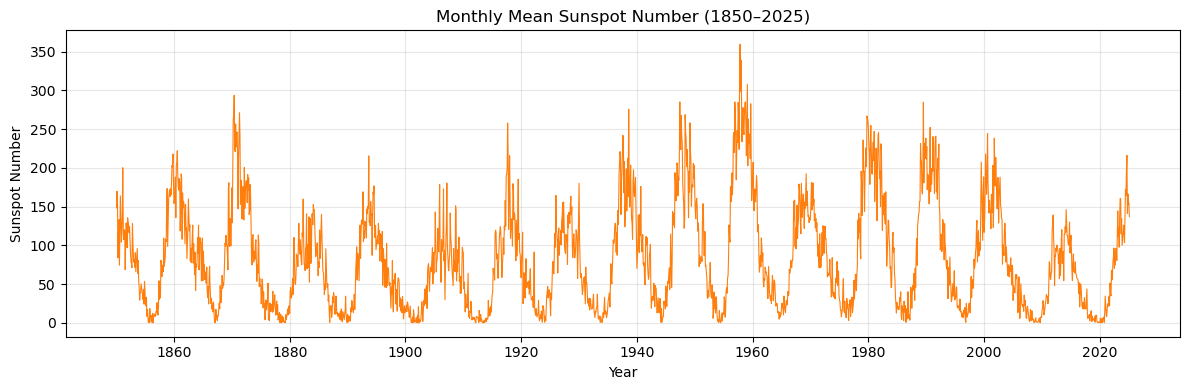

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(ts_monthly.index, ts_monthly.values, color='tab:orange', linewidth=0.8)
plt.title("Monthly Mean Sunspot Number (1850–2025)")
plt.xlabel("Year")
plt.ylabel("Sunspot Number")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Prepare data and import wavelet library

In [3]:
import pywt  # PyWavelets

# 1) Put the monthly series into a numpy array and remove the mean
x = ts_monthly.values.astype(float)
x = x - x.mean()          # demean so we focus on oscillations

# 2) Basic info
N = len(x)
dt = 1.0   # time step in *months* (one sample per month)

print("Length N:", N)
print("Time step dt (months):", dt)


Length N: 2101
Time step dt (months): 1.0


### Choose wavelet + map scales → periods

In [4]:
# Choose the mother wavelet (Morlet)
wavelet = 'morl'

# Candidate scales (these are like "zoom levels")
scales = np.arange(1, 400)   # we will later keep only the scales we need

# Convert scales to equivalent frequencies and periods
freqs_cpm = pywt.scale2frequency(wavelet, scales) / dt   # cycles per month
periods_months = 1.0 / freqs_cpm
periods_years = periods_months / 12.0

print("Approximate period range covered by these scales (years):")
print("min:", periods_years.min(), "max:", periods_years.max())
print("First 10 periods (years):", periods_years[:10])


Approximate period range covered by these scales (years):
min: 0.10256410256410257 max: 40.92307692307693
First 10 periods (years): [0.1025641  0.20512821 0.30769231 0.41025641 0.51282051 0.61538462
 0.71794872 0.82051282 0.92307692 1.02564103]


In [5]:
# 1) Keep only scales corresponding to periods between 1 and 25 years
mask = (periods_years >= 1.0) & (periods_years <= 25.0)
scales_sel = scales[mask]
periods_sel_years = periods_years[mask]

print("Number of selected scales:", len(scales_sel))
print("Selected period range (years):", periods_sel_years.min(), "to", periods_sel_years.max())

# 2) Continuous Wavelet Transform on the demeaned series
coeffs, freqs_cpm_sel = pywt.cwt(x, scales_sel, wavelet, sampling_period=dt)
# coeffs shape: [n_scales, N]

print("CWT coefficient array shape:", coeffs.shape)  # (n_scales, N)


Number of selected scales: 234
Selected period range (years): 1.0256410256410255 to 24.923076923076923
CWT coefficient array shape: (234, 2101)


### wavelet scalogram: time–period heatmap

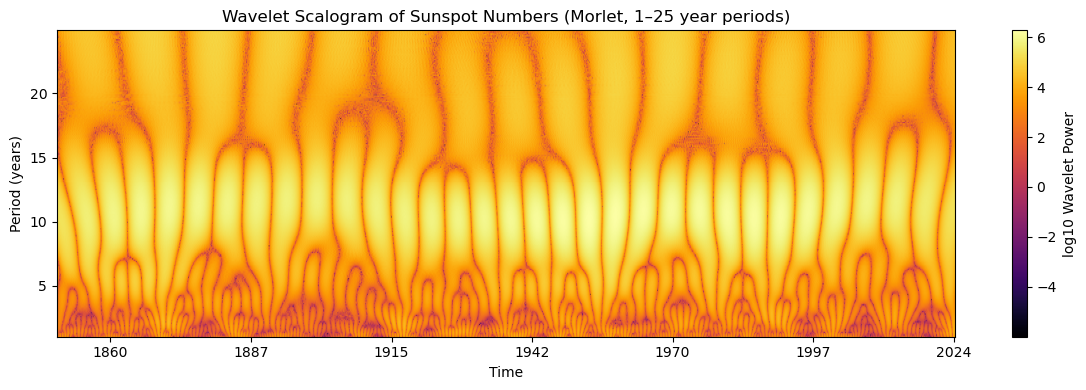

In [6]:
import matplotlib.dates as mdates

# 1) Wavelet power (squared magnitude of coefficients)
power = np.abs(coeffs)**2
power_log = np.log10(power + 1e-6)   # log scale to compress dynamic range

# 2) Time axis in matplotlib date format
t = ts_monthly.index
t_num = mdates.date2num(t)

# 3) Plot
fig, ax = plt.subplots(figsize=(12,4))

extent = [t_num[0], t_num[-1],
          periods_sel_years.min(), periods_sel_years.max()]

im = ax.imshow(
    power_log,
    extent=extent,
    aspect='auto',
    origin='lower',
    cmap='inferno'   # nice orange/purple palette
)

ax.set_ylabel("Period (years)")
ax.set_xlabel("Time")
ax.set_title("Wavelet Scalogram of Sunspot Numbers (Morlet, 1–25 year periods)")

# Format x-axis as years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("log10 Wavelet Power")

plt.tight_layout()
plt.show()


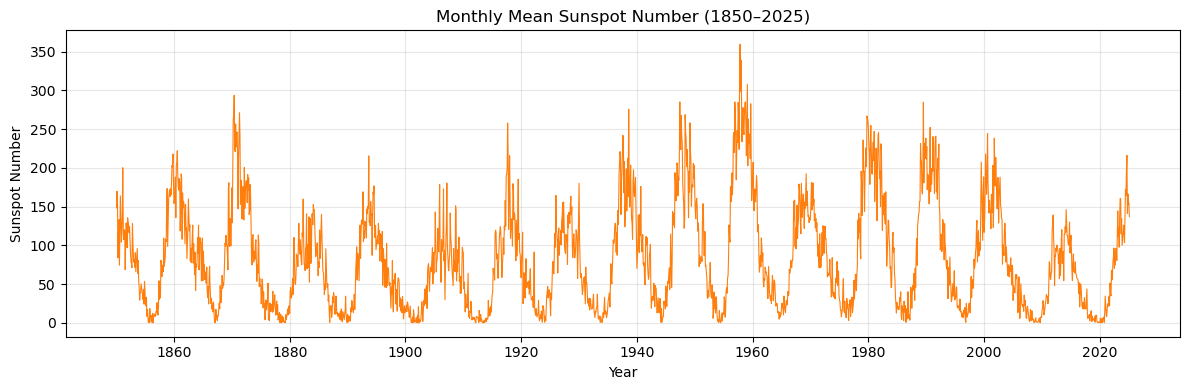

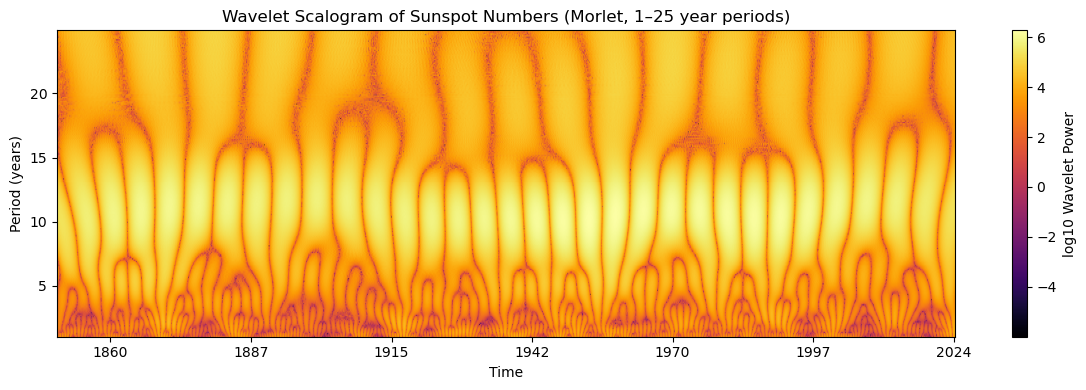

In [7]:
import matplotlib.dates as mdates

# ----- 1) Time series plot -----
fig1, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(ts_monthly.index, ts_monthly.values, color='tab:orange', linewidth=0.8)
ax1.set_title("Monthly Mean Sunspot Number (1850–2025)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Sunspot Number")
ax1.grid(alpha=0.3)
fig1.tight_layout()
fig1.savefig("sunspots_monthly_timeseries.png", dpi=500, bbox_inches="tight")
plt.show()

# ----- 2) Wavelet scalogram -----
power = np.abs(coeffs)**2
power_log = np.log10(power + 1e-6)
t = ts_monthly.index
t_num = mdates.date2num(t)

fig2, ax2 = plt.subplots(figsize=(12,4))
extent = [t_num[0], t_num[-1],
          periods_sel_years.min(), periods_sel_years.max()]

im = ax2.imshow(
    power_log,
    extent=extent,
    aspect='auto',
    origin='lower',
    cmap='inferno'
)
ax2.set_ylabel("Period (years)")
ax2.set_xlabel("Time")
ax2.set_title("Wavelet Scalogram of Sunspot Numbers (Morlet, 1–25 year periods)")
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
cbar = fig2.colorbar(im, ax=ax2)
cbar.set_label("log10 Wavelet Power")
fig2.tight_layout()
fig2.savefig("sunspots_wavelet_scalogram.png", dpi=500, bbox_inches="tight")
plt.show()


### Global wavelet spectrum

Dominant period from global wavelet spectrum ≈ 10.77 years


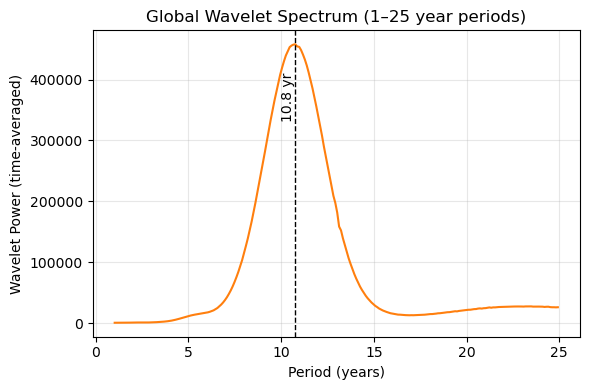

In [8]:
# Global wavelet spectrum: average power over time for each scale
power = np.abs(coeffs)**2          # (n_scales, N)
global_power = power.mean(axis=1)  # (n_scales,)

# Find dominant period
idx_max = np.argmax(global_power)
dominant_period = periods_sel_years[idx_max]
print(f"Dominant period from global wavelet spectrum ≈ {dominant_period:.2f} years")

# Plot and save
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(periods_sel_years, global_power, color='tab:orange', linewidth=1.5)
ax.set_xlabel("Period (years)")
ax.set_ylabel("Wavelet Power (time-averaged)")
ax.set_title("Global Wavelet Spectrum (1–25 year periods)")
ax.grid(alpha=0.3)

# Mark dominant period
ax.axvline(dominant_period, color='k', linestyle='--', linewidth=1)
ax.text(dominant_period, global_power.max()*0.9,
        f"{dominant_period:.1f} yr", rotation=90,
        va='top', ha='right')

fig.tight_layout()
fig.savefig("sunspots_global_wavelet_spectrum.png", dpi=500, bbox_inches="tight")
plt.show()


### Dominant period vs time (7–15 year band)

Band scales: (78, 2101) period range: 7.076923076923077 to 14.974358974358976 years
min     7.076923
25%    10.256410
50%    10.871795
75%    11.487179
max    14.974359
dtype: float64


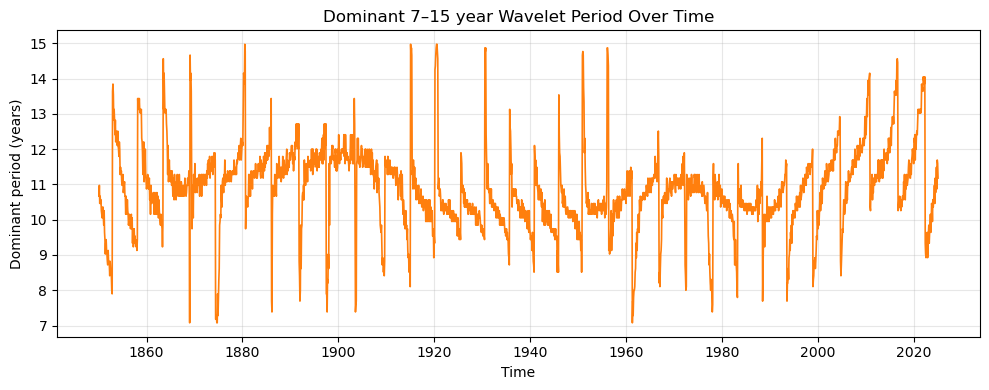

In [9]:
# Use wavelet power from before
power = np.abs(coeffs)**2   # shape: (n_scales, N)

# 1) Focus on the 7–15 year band
band_mask = (periods_sel_years >= 7.0) & (periods_sel_years <= 15.0)
periods_band = periods_sel_years[band_mask]        # (n_band_scales,)
power_band = power[band_mask, :]                   # (n_band_scales, N)

print("Band scales:", power_band.shape, "period range:",
      periods_band.min(), "to", periods_band.max(), "years")

# 2) For each time point, find the period with maximum power in this band
idx_max_time = np.argmax(power_band, axis=0)       # (N,)
dominant_period_time = periods_band[idx_max_time]  # (N,)

# 3) Basic stats
print(pd.Series(dominant_period_time).describe()[["min","25%","50%","75%","max"]])

# 4) Plot and save
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(ts_monthly.index, dominant_period_time, color='tab:orange', linewidth=1.2)
ax.set_ylabel("Dominant period (years)")
ax.set_xlabel("Time")
ax.set_title("Dominant 7–15 year Wavelet Period Over Time")
ax.grid(alpha=0.3)

fig.tight_layout()
fig.savefig("sunspots_wavelet_dominant_period_7_15yr.png", dpi=300, bbox_inches="tight")
plt.show()


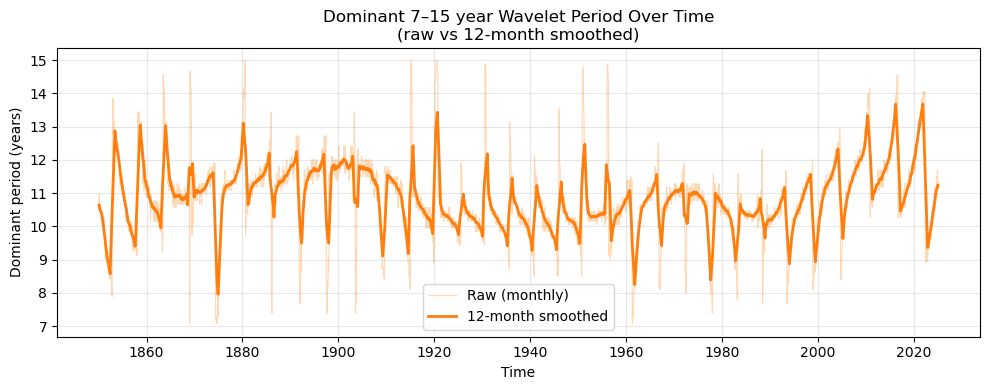

Mean dominant period (smoothed): 10.856679581810472
Std dev (smoothed): 0.8614104922917637


In [10]:
# 10) Smoothed dominant period (12-month rolling mean)

dom_series = pd.Series(dominant_period_time, index=ts_monthly.index)
dom_smooth = dom_series.rolling(window=12, center=True, min_periods=6).mean()

fig, ax = plt.subplots(figsize=(10,4))

# raw in light color
ax.plot(dom_series.index, dom_series.values,
        color='tab:orange', alpha=0.3, linewidth=0.8, label='Raw (monthly)')

# smoothed in bold
ax.plot(dom_smooth.index, dom_smooth.values,
        color='tab:orange', linewidth=2.0, label='12-month smoothed')

ax.set_ylabel("Dominant period (years)")
ax.set_xlabel("Time")
ax.set_title("Dominant 7–15 year Wavelet Period Over Time\n(raw vs 12-month smoothed)")
ax.grid(alpha=0.3)
ax.legend()

fig.tight_layout()
fig.savefig("sunspots_wavelet_dominant_period_smoothed.png",
            dpi=300, bbox_inches="tight")
plt.show()

# Print mean and std of smoothed series (ignoring NaNs)
print("Mean dominant period (smoothed):", dom_smooth.mean())
print("Std dev (smoothed):", dom_smooth.std())
